In [90]:
import os, sys
%pylab inline
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Helper Functions

First, a helper function to plot the pairs of voltages that will achieve a desired eye angle.
We will want a particular linear path through the solutions. This will be defined by connected our desired starting point $L_0$ on the $\theta = -\pi/2$ line, and our end point $L_1$ on the $\theta = \pi/2$ line. We will plot that line as well.

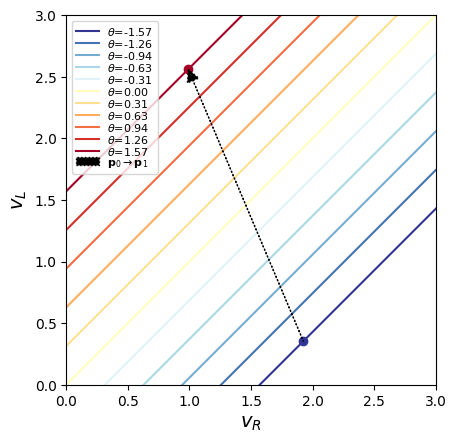

In [91]:
def plot_sols(L0=0.5, L1=1.4):
    th_min, th_max = -pi/2, pi/2

    th_vals = linspace(th_min, th_max, 11)

    # Starting and ending points
    p0 = np.array([pi/2, 0]) + L0*np.array([1,1])/sqrt(2)
    p1 = np.array([0, pi/2]) + L1*np.array([1,1])/sqrt(2)

    col_fun = lambda th: cm.RdYlBu_r((th-th_min)/(th_max-th_min))

    v_R = linspace(0, 3*pi, 10)
    for th in th_vals:
        v_L = v_R + th
        plot(v_R, v_L, color=col_fun(th), label=f'$\\theta$={th:.2f}')
    plot(*p0, 'o', color=col_fun(th_min))
    plot(*p1, 'o', color=col_fun(th_max))
    # Plot an arrow from p0 to p1 whose arrowhead is at p1
    arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True, zorder=10, linestyle=":", label="$\\mathbf{p}_0 \\to \\mathbf{p}_1$")
    axis('square')
    xlim(0, 3); ylim(0, 3)
    xlabel('$v_R$', fontsize=14); ylabel('$v_L$', fontsize=14)
    legend(labelspacing=0, fontsize=8)
    return p0, p1

p0, p1 = plot_sols()

It will be useful to plot eigenvectors on the same plot.

In [89]:
def plot_eigs(p_cent, e1, e2):
  arrow(p_cent[0], p_cent[1], e1[0], e1[1], head_width=0.1, head_length=0.1, fc='red', ec='red', length_includes_head=True, zorder=10, linestyle=":", label="$\\mathbf{q}_0$")
  arrow(p_cent[0], p_cent[1], e2[0], e2[1], head_width=0.1, head_length=0.1, fc='green', ec='green', length_includes_head=True, zorder=10, linestyle=":", label="$\\mathbf{q}_1$")
  legend(labelspacing=0, fontsize=8)


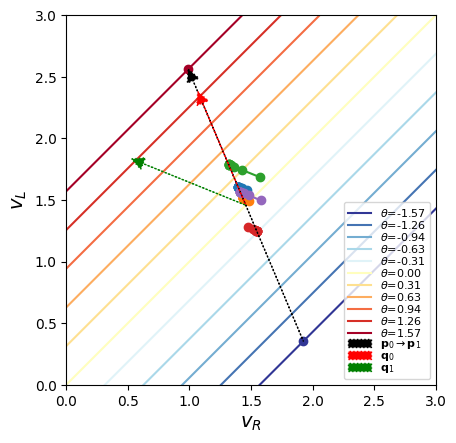

In [75]:
# We want to build a linear system that is a line attractor along p0-p1.
# du/dt = -u + Tv + h
# v = Gu + v_p
# dv/dt = Gdu/dt = -Gu + GTv + Gh = -Gu -v_p + GTv + Gh + v_p = -v + GTv + (Gh + v_p) = -v + Wv + f
# Let P have the eigenvectors of W
# W P = P D
# Then dv/dt = - v + P D P^{-1} v + f
# d(P^{-1} v)/dt = - P^{-1} v + D P^{-1} v + P^{-1} f
# Let y = P^{-1} v
# dy/dt = - y + D y + P^{-1} f
# Then y_i(t) = y_i(0) e^-(1-d_i)t + (P^{-1} f)_i (1 - e^-(1-d_i)t)/(1-d_i)
# If we make d_1 = 1, then the first component of y is a perfect integrator.
# We can make the other eigenvalues < 1 so that the other components decay to 0.
# We then have a line attractor along the first eigenvector of W.
#random.seed(1)
p0, p1 = plot_sols()
p_cent = (p0 + p1)/2
e1 = (p1 - p0)/norm(p1 - p0)
# Make e2 a random rotation of e1
rot = rand()*pi-pi/2
rot = pi/4
R = array([[cos(rot), -sin(rot)], [sin(rot), cos(rot)]])
e2 = R @ e1

plot_eigs(p_cent, e1, e2)

D = [1, 0.2]
P = np.column_stack((e1, e2))
iP= inv(P)
W = P @ np.diag(D) @ iP
p_cent_ = iP @ p_cent
f2_ = p_cent_[1] * (1 - D[1])
f_ = np.array([0, f2_])
f = P @ f_
# Simulate dv/dt = -v + Wv + f
T = 10
dvdt = lambda v, t: -v + W @ v + f
for i in range(5):
    v_init = p_cent + 0.5*(rand(2)-0.5)
    v_sol = odeint(dvdt, v_init, linspace(0, T, 10))
    plot(v_sol[:,0], v_sol[:,1], 'o-')

# Initialization

Let's try initializing so that we're on the $
theta = 0$ line. This just means setting our coordinate along the attractor dimension to whatever of $\mathbf p_0$, then moving it half-way along towards $\mathbf p_1$. That is $$\tilde v_{01} = \tilde p_{01} + {1\over 2} \|\mathbf p_1 - \mathbf p_0\|.$$ We can set the other coordinate arbitrarily.

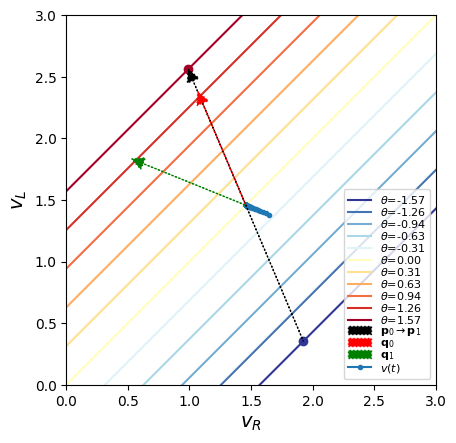

In [81]:
p0, p1 = plot_sols()

plot_eigs(p_cent, e1, e2)

# Get the eigenvector coordinates of p0 and p1
p0_ = iP @ p0
p1_ = iP @ p1

v_init_1 = p0_[0] + 0.5 * norm(p1 - p0)
v_init_2 = p0_[1] + randn() * 1

v_init_ = np.array([v_init_1, v_init_2])
v_init = P @ v_init_

v_sol = odeint(dvdt, v_init, linspace(0, T, 50))
plot(v_sol[:,0], v_sol[:,1], 'o-', markersize=3, label="$v(t)$")
legend(labelspacing=0,fontsize=8)

# Driving the attractor

To drive the attractor to different voltages (and therefore different eye directions) we will feed it with impulses along its attractor direction. Impulses are hard to directly incorporate into the ODE integration. Their effect is to instantaneously change the voltages by the amplitude of the impulse. So we will simulate their effect by initializing the ODE integration at whatever the last value was before the impulse, plus the instantaneous change due to the impulse.

In [85]:
def get_angle(v):
  v_ = iP @ v # Get eigenvector coordinates
  # Angle is our relative distance along the attractor
  theta = -pi/2 + (v_[0] - p0_[0])/(p1_[0] - p0_[0]) * pi
  return theta

# The previous value of the voltage is given by our location along the attractor
v_sol = odeint(dvdt, v_init, linspace(0, T, 50))
theta_prev = get_angle(v_sol[-1])
print(f"Previous angle: {theta_prev:.2g}")
theta_next = pi/6
dtheta = theta_next - theta_prev
dv_1 = norm(p1 - p0) * dtheta/pi
dv   = P[:,0] * dv_1
v_post = v_sol[-1] + dv
v_sol_next = odeint(dvdt, v_post, linspace(0, T, 50))
theta_last = get_angle(v_sol_next[-1])
print(f"Next angle: {theta_last:.2g} vs. Desired angle: {theta_next:.2g}")

Previous angle: 4.4e-16
Next angle: 0.52 vs. Desired angle: 0.52
